In [4]:
import pandas as pd
import numpy as np
import scipy.stats as st
from datetime import datetime
import matplotlib.pyplot as plt
import math
%matplotlib inline
import glob

In [5]:
filenames = sorted(glob.glob('/Users/tatyanach/Desktop/Cognitive Lab/9 dots/9d_exp_1/*.csv'))

In [6]:
#Define the input values
dot_radius = 180.0
max_dot_error = dot_radius / 2.0
outer_border_dist = 500.0
max_inline_gap = 1500.0
prolong_len = 3000.0

In [7]:
#define the distance between points p and q passed as follows
#p = [p_x, p_y]
#q = [q_x, q_y]
def distance_between_two_dots(p, q):
    return math.sqrt((p[0] - q[0])**2 + (p[1] - q[1])**2)

In [8]:
def on_the_line(dots_list):
    dots_list = list(set(dots_list))
    if len(dots_list) < 3:
        return True
    elif len(dots_list) > 4:
        return 'More than 4 dots - strange!'
    elif len(dots_list) == 4:
        return False
    elif len(dots_list) == 3:
        x1 = dots.loc[dots_list[0], 'center_x']
        y1 = dots.loc[dots_list[0], 'center_y']
        x2 = dots.loc[dots_list[1], 'center_x']
        y2 = dots.loc[dots_list[1], 'center_y']
        x3 = dots.loc[dots_list[2], 'center_x']
        y3 = dots.loc[dots_list[2], 'center_y']
        determinant = x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2)
  
        if (determinant == 0):
            return True
        else:
            return False

In [9]:
# line1 = [[x,y], [x,y]], line2 = [[x,y], [x,y]]
def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
        return -1

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return [x, y]

In [10]:
# line = [[x,y], [x,y]]
def prolong(line, delta, start, end):
    A = line[0]
    B = line[1]
    AB_len = np.sqrt(np.square(B[0]-A[0]) + np.square(B[1]-A[1]))
    AB_n = [(B[0]-A[0])/AB_len, (B[1]-A[1])/AB_len]
    
    new_start = A
    new_end = B
    new_start_x = A[0]
    new_start_y = A[1]
    new_end_x = B[0]
    new_end_y = B[1]
    
    if start == 1:
        new_start_x = B[0] - AB_n[0] * (AB_len + delta)
        new_start_y = B[1] - AB_n[1] * (AB_len + delta)
    if end == 1:
        new_end_x = A[0] + AB_n[0] * (AB_len + delta)
        new_end_y = A[1] + AB_n[1] * (AB_len + delta)
    new_start = [new_start_x, new_start_y]
    new_end = [new_end_x, new_end_y]
    return [new_start, new_end]

In [11]:
def get_skeleton(trj):
    skeleton = pd.DataFrame(columns = ['type', 'dot_number', 'x_value', 'y_value'])
    current_element = 'none'
    next_element = 'none'
    i = 0
    while i < len(trj):
        if i > 0 and distance_between_two_dots(trj.iloc[i, 2:4], trj.iloc[i-1, 2:4]) > max_inline_gap:
            return 'invalid try - line breaks'
        for j in range(len(dots)): #checking dots intersection
            if distance_between_two_dots(trj.iloc[i, 2:4], dots.iloc[j, 4:6]) < dot_radius + max_dot_error:
                next_element = j
                if next_element != current_element:
                    skeleton = skeleton.append({'type': 'dot', 'dot_number': j, 'x_value': dots.loc[j,'center_x'], 'y_value': dots.loc[j,'center_y']}, ignore_index = True)
                    current_element = next_element

        #checking if out of box 
        if (trj.iloc[i, 2] < min(dots['center_x']) - outer_border_dist 
                        or trj.iloc[i, 2] > max(dots['center_x']) + outer_border_dist
                        or trj.iloc[i, 3] < min(dots['center_y']) - outer_border_dist
                        or trj.iloc[i, 3] > max(dots['center_y']) + outer_border_dist):
            next_element = -1
            if next_element != current_element:
                    skeleton = skeleton.append({'type': 'oob', 'dot_number': -1, 'x_value': 'unknown', 'y_value': 'unknown'}, ignore_index = True)
                    current_element = next_element
        #skipping 4 out of 5 steps to be faster
        if i < len(trj) - 6:
            i = i + 5
        else:
            i = i + 1

    skeleton = skeleton.reset_index(drop = True)
    return skeleton 

In [12]:
def get_lines(trj):
    skeleton = get_skeleton(trj)
    display(skeleton)
    lines = pd.DataFrame(columns = ['dots_intersected', 'start', 'end', 'start_oob', 'end_oob'])
    current_line_dots = []
    current_line_start_oob = 0
    current_line_end_oob = 0
    for i in range(len(skeleton)):
        if skeleton.loc[i, 'type'] == 'oob':
            if i > 0: 
                current_line_end_oob = 1
                lines = lines.append({'dots_intersected': current_line_dots, 'start': dots.iloc[current_line_dots[0], 4:6].tolist(), 
                                      'end': dots.iloc[current_line_dots[len(current_line_dots) - 1], 4:6].tolist(), 
                                      'start_oob': current_line_start_oob, 'end_oob': current_line_end_oob}, 
                                     ignore_index = True)
            current_line_dots = []
            current_line_end_oob = 0
            current_line_start_oob = 1    
                
        else:
            try_add_another_dot = current_line_dots.copy()
            try_add_another_dot.append(skeleton.loc[i, 'dot_number'])
            
            if on_the_line(try_add_another_dot):
                current_line_dots.append(skeleton.loc[i, 'dot_number'])
            else:
                lines = lines.append({'dots_intersected': current_line_dots, 'start': dots.iloc[current_line_dots[0], 4:6].tolist(), 
                                  'end': dots.iloc[current_line_dots[len(current_line_dots) - 1], 4:6].tolist(), 
                                  'start_oob': current_line_start_oob, 'end_oob': current_line_end_oob}, 
                                 ignore_index = True)
                current_line_dots = [current_line_dots[len(current_line_dots) - 1]]
                current_line_dots.append(skeleton.loc[i, 'dot_number'])
                current_line_end_oob = 0
                current_line_start_oob = 0

            if i == len(skeleton) - 1: #if it's the last dot in the series
                lines = lines.append({'dots_intersected': current_line_dots, 'start': dots.iloc[current_line_dots[0], 4:6].tolist(), 
                                  'end': dots.iloc[current_line_dots[len(current_line_dots) - 1], 4:6].tolist(), 
                                  'start_oob': current_line_start_oob, 'end_oob': current_line_end_oob}, 
                                 ignore_index = True)

    lines = lines.reset_index(drop = True)
    
    #prolonging lines when oob
    for l in range(len(lines)):
        if l == 0 and lines.loc[l, 'start_oob'] == 1:
            lines.iloc[l, 1] = prolong(lines.iloc[l, 1:3], prolong_len, 1, 0)[0]
        if l == len(lines) - 1 and lines.loc[l, 'end_oob'] == 1:
            lines.iloc[l, 2] = prolong(lines.iloc[l, 1:3], prolong_len, 0, 1)[1]
        if l < len(lines) - 1:
            if (lines.loc[l, 'end_oob'] == 1 and lines.loc[l + 1, 'start_oob'] == 1 
            and line_intersection(lines.iloc[l, 1:3], lines.iloc[l + 1, 1:3]) != -1):
                intersection = line_intersection(lines.iloc[l, 1:3], lines.iloc[l + 1, 1:3])
                if (intersection[0] < min(dots['center_x']) - outer_border_dist 
                or intersection[0] > max(dots['center_x']) + outer_border_dist
                or intersection[1] < min(dots['center_y']) - outer_border_dist
                or intersection[1] > max(dots['center_y']) + outer_border_dist):
                    lines.iloc[l, 2] = intersection
                    lines.iloc[l + 1, 1] = intersection
                else:
                    lines.iloc[l, 2] = prolong(lines.iloc[l, 1:3], prolong_len, 0, 1)[1]
                    lines.iloc[l + 1, 1] = prolong(lines.iloc[l + 1, 1:3], prolong_len, 1, 0)[0]     
            elif (lines.loc[l, 'end_oob'] == 1 and lines.loc[l + 1, 'start_oob'] == 1 
            and line_intersection(lines.iloc[l, 1:3], lines.iloc[l + 1, 1:3]) == -1):
                lines.iloc[l, 2] = prolong(lines.iloc[l, 1:3], prolong_len, 0, 1)[1]
                lines.iloc[l + 1, 1] = prolong(lines.iloc[l + 1, 1:3], prolong_len, 1, 0)[0]
                
    #if we have 1-dot lines
    for l in range(len(lines)):
        if len(lines.loc[l, 'dots_intersected']) == 1:
            if l > 0:
                lines.loc[l, 'start'] = lines.loc[l - 1, 'end']
            if l < len(lines) - 1:
                lines.loc[l, 'end'] = lines.loc[l + 1, 'start']
            
    return lines

the dots


,left_border,upper_border,width,height,center_x,center_y
0,4734.0,3912.0,360.0,360.0,4914.0,4092.0
1,5607.0,3912.0,360.0,360.0,5787.0,4092.0
2,6480.0,3912.0,360.0,360.0,6660.0,4092.0
3,4734.0,3048.0,360.0,360.0,4914.0,3228.0
4,5607.0,3048.0,360.0,360.0,5787.0,3228.0
5,6480.0,3048.0,360.0,360.0,6660.0,3228.0
6,4734.0,2184.0,360.0,360.0,4914.0,2364.0
7,5607.0,2184.0,360.0,360.0,5787.0,2364.0
8,6480.0,2184.0,360.0,360.0,6660.0,2364.0


participant_id: 4
try number: 0


,type,dot_number,x_value,y_value
0,dot,8,6660.0,2364.0
1,dot,4,5787.0,3228.0
2,dot,0,4914.0,4092.0


,dots_intersected,start,end,start_oob,end_oob
0,"[8, 4, 0]","[6660.0, 2364.0]","[4914.0, 4092.0]",0,0


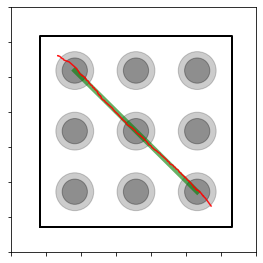

participant_id: 4
try number: 1


,type,dot_number,x_value,y_value
0,dot,6,4914.0,2364.0
1,dot,7,5787.0,2364.0
2,dot,8,6660.0,2364.0
3,dot,3,4914.0,3228.0
4,dot,4,5787.0,3228.0
5,dot,5,6660.0,3228.0
6,dot,2,6660.0,4092.0


,dots_intersected,start,end,start_oob,end_oob
0,"[6, 7, 8]","[4914.0, 2364.0]","[6660.0, 2364.0]",0,0
1,"[8, 3]","[6660.0, 2364.0]","[4914.0, 3228.0]",0,0
2,"[3, 4, 5]","[4914.0, 3228.0]","[6660.0, 3228.0]",0,0
3,"[5, 2]","[6660.0, 3228.0]","[6660.0, 4092.0]",0,0


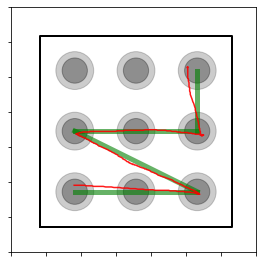

participant_id: 4
try number: 2


,type,dot_number,x_value,y_value
0,dot,0,4914.0,4092.0
1,dot,1,5787.0,4092.0
2,dot,2,6660.0,4092.0
3,dot,5,6660.0,3228.0
4,dot,8,6660.0,2364.0
5,dot,4,5787.0,3228.0
6,dot,3,4914.0,3228.0


,dots_intersected,start,end,start_oob,end_oob
0,"[0, 1, 2]","[4914.0, 4092.0]","[6660.0, 4092.0]",0,0
1,"[2, 5, 8]","[6660.0, 4092.0]","[6660.0, 2364.0]",0,0
2,"[8, 4]","[6660.0, 2364.0]","[5787.0, 3228.0]",0,0
3,"[4, 3]","[5787.0, 3228.0]","[4914.0, 3228.0]",0,0


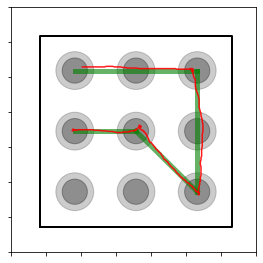

participant_id: 4
try number: 3


,type,dot_number,x_value,y_value
0,dot,1,5787.0,4092.0
1,dot,8,6660.0,2364.0
2,dot,5,6660.0,3228.0
3,dot,2,6660.0,4092.0
4,dot,4,5787.0,3228.0
5,dot,6,4914.0,2364.0
6,dot,7,5787.0,2364.0


,dots_intersected,start,end,start_oob,end_oob
0,"[1, 8]","[5787.0, 4092.0]","[6660.0, 2364.0]",0,0
1,"[8, 5, 2]","[6660.0, 2364.0]","[6660.0, 4092.0]",0,0
2,"[2, 4, 6]","[6660.0, 4092.0]","[4914.0, 2364.0]",0,0
3,"[6, 7]","[4914.0, 2364.0]","[5787.0, 2364.0]",0,0


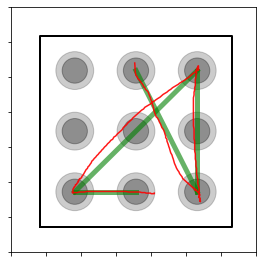

participant_id: 4
try number: 4


,type,dot_number,x_value,y_value
0,dot,6,4914.0,2364.0
1,dot,3,4914.0,3228.0
2,dot,0,4914.0,4092.0
3,dot,4,5787.0,3228.0
4,dot,8,6660.0,2364.0
5,dot,5,6660.0,3228.0
6,dot,2,6660.0,4092.0
7,dot,1,5787.0,4092.0


,dots_intersected,start,end,start_oob,end_oob
0,"[6, 3, 0]","[4914.0, 2364.0]","[4914.0, 4092.0]",0,0
1,"[0, 4, 8]","[4914.0, 4092.0]","[6660.0, 2364.0]",0,0
2,"[8, 5, 2]","[6660.0, 2364.0]","[6660.0, 4092.0]",0,0
3,"[2, 1]","[6660.0, 4092.0]","[5787.0, 4092.0]",0,0


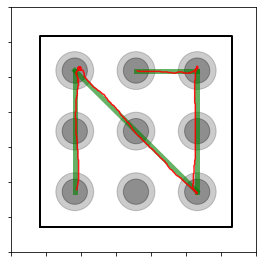

participant_id: 4
try number: 5


,type,dot_number,x_value,y_value
0,dot,6,4914.0,2364.0
1,dot,7,5787.0,2364.0
2,dot,8,6660.0,2364.0
3,dot,5,6660.0,3228.0
4,dot,2,6660.0,4092.0
5,dot,1,5787.0,4092.0
6,dot,0,4914.0,4092.0
7,dot,4,5787.0,3228.0


,dots_intersected,start,end,start_oob,end_oob
0,"[6, 7, 8]","[4914.0, 2364.0]","[6660.0, 2364.0]",0,0
1,"[8, 5, 2]","[6660.0, 2364.0]","[6660.0, 4092.0]",0,0
2,"[2, 1, 0]","[6660.0, 4092.0]","[4914.0, 4092.0]",0,0
3,"[0, 4]","[4914.0, 4092.0]","[5787.0, 3228.0]",0,0


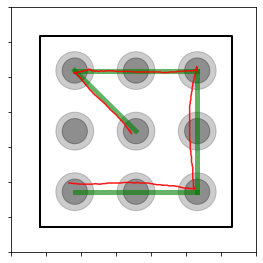

participant_id: 4
try number: 6


,type,dot_number,x_value,y_value
0,dot,3,4914.0,3228.0
1,dot,4,5787.0,3228.0
2,dot,5,6660.0,3228.0
3,dot,2,6660.0,4092.0
4,dot,1,5787.0,4092.0
5,dot,0,4914.0,4092.0
6,dot,3,4914.0,3228.0
7,dot,6,4914.0,2364.0


,dots_intersected,start,end,start_oob,end_oob
0,"[3, 4, 5]","[4914.0, 3228.0]","[6660.0, 3228.0]",0,0
1,"[5, 2]","[6660.0, 3228.0]","[6660.0, 4092.0]",0,0
2,"[2, 1, 0]","[6660.0, 4092.0]","[4914.0, 4092.0]",0,0
3,"[0, 3, 6]","[4914.0, 4092.0]","[4914.0, 2364.0]",0,0


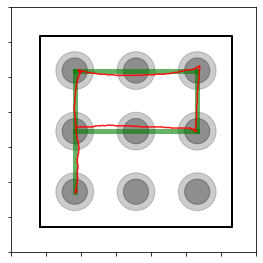

participant_id: 4
try number: 7


,type,dot_number,x_value,y_value
0,dot,5,6660.0,3228.0
1,dot,1,5787.0,4092.0
2,dot,0,4914.0,4092.0
3,dot,4,5787.0,3228.0
4,dot,8,6660.0,2364.0
5,dot,7,5787.0,2364.0
6,dot,6,4914.0,2364.0


,dots_intersected,start,end,start_oob,end_oob
0,"[5, 1]","[6660.0, 3228.0]","[5787.0, 4092.0]",0,0
1,"[1, 0]","[5787.0, 4092.0]","[4914.0, 4092.0]",0,0
2,"[0, 4, 8]","[4914.0, 4092.0]","[6660.0, 2364.0]",0,0
3,"[8, 7, 6]","[6660.0, 2364.0]","[4914.0, 2364.0]",0,0


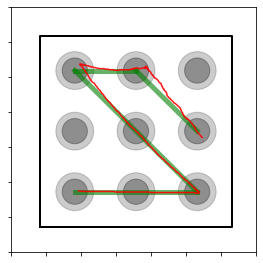

participant_id: 4
try number: 8


,type,dot_number,x_value,y_value
0,dot,8,6660.0,2364.0
1,dot,5,6660.0,3228.0
2,dot,2,6660.0,4092.0
3,dot,4,5787.0,3228.0
4,dot,6,4914.0,2364.0
5,dot,3,4914.0,3228.0
6,dot,0,4914.0,4092.0
7,dot,1,5787.0,4092.0


,dots_intersected,start,end,start_oob,end_oob
0,"[8, 5, 2]","[6660.0, 2364.0]","[6660.0, 4092.0]",0,0
1,"[2, 4, 6]","[6660.0, 4092.0]","[4914.0, 2364.0]",0,0
2,"[6, 3, 0]","[4914.0, 2364.0]","[4914.0, 4092.0]",0,0
3,"[0, 1]","[4914.0, 4092.0]","[5787.0, 4092.0]",0,0


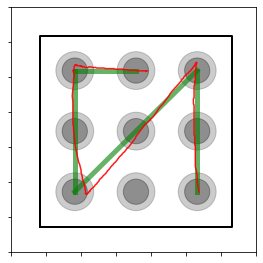

participant_id: 4
try number: 9


,type,dot_number,x_value,y_value
0,dot,8,6660.0,2364.0
1,dot,5,6660.0,3228.0
2,dot,4,5787.0,3228.0
3,dot,3,4914.0,3228.0
4,dot,6,4914.0,2364.0
5,dot,7,5787.0,2364.0


,dots_intersected,start,end,start_oob,end_oob
0,"[8, 5]","[6660.0, 2364.0]","[6660.0, 3228.0]",0,0
1,"[5, 4, 3]","[6660.0, 3228.0]","[4914.0, 3228.0]",0,0
2,"[3, 6]","[4914.0, 3228.0]","[4914.0, 2364.0]",0,0
3,"[6, 7]","[4914.0, 2364.0]","[5787.0, 2364.0]",0,0


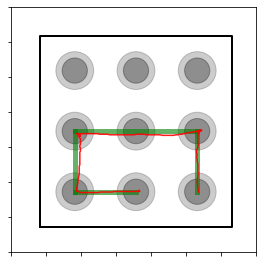

participant_id: 4
try number: 10


,type,dot_number,x_value,y_value
0,dot,3,4914.0,3228.0
1,dot,6,4914.0,2364.0
2,dot,7,5787.0,2364.0
3,dot,8,6660.0,2364.0
4,dot,4,5787.0,3228.0
5,dot,0,4914.0,4092.0
6,dot,1,5787.0,4092.0
7,dot,2,6660.0,4092.0


,dots_intersected,start,end,start_oob,end_oob
0,"[3, 6]","[4914.0, 3228.0]","[4914.0, 2364.0]",0,0
1,"[6, 7, 8]","[4914.0, 2364.0]","[6660.0, 2364.0]",0,0
2,"[8, 4, 0]","[6660.0, 2364.0]","[4914.0, 4092.0]",0,0
3,"[0, 1, 2]","[4914.0, 4092.0]","[6660.0, 4092.0]",0,0


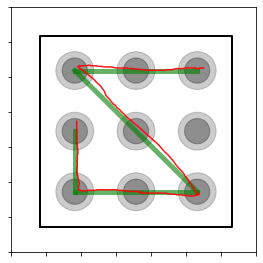

participant_id: 4
try number: 11


,type,dot_number,x_value,y_value
0,dot,6,4914.0,2364.0
1,dot,3,4914.0,3228.0
2,dot,0,4914.0,4092.0
3,dot,4,5787.0,3228.0
4,dot,8,6660.0,2364.0
5,dot,5,6660.0,3228.0
6,dot,2,6660.0,4092.0
7,dot,1,5787.0,4092.0


,dots_intersected,start,end,start_oob,end_oob
0,"[6, 3, 0]","[4914.0, 2364.0]","[4914.0, 4092.0]",0,0
1,"[0, 4, 8]","[4914.0, 4092.0]","[6660.0, 2364.0]",0,0
2,"[8, 5, 2]","[6660.0, 2364.0]","[6660.0, 4092.0]",0,0
3,"[2, 1]","[6660.0, 4092.0]","[5787.0, 4092.0]",0,0


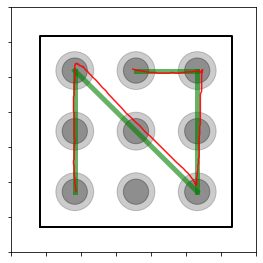

participant_id: 4
try number: 12


,type,dot_number,x_value,y_value
0,dot,6,4914.0,2364.0
1,dot,7,5787.0,2364.0
2,dot,8,6660.0,2364.0
3,dot,4,5787.0,3228.0
4,dot,0,4914.0,4092.0
5,dot,1,5787.0,4092.0
6,dot,2,6660.0,4092.0
7,dot,5,6660.0,3228.0


,dots_intersected,start,end,start_oob,end_oob
0,"[6, 7, 8]","[4914.0, 2364.0]","[6660.0, 2364.0]",0,0
1,"[8, 4, 0]","[6660.0, 2364.0]","[4914.0, 4092.0]",0,0
2,"[0, 1, 2]","[4914.0, 4092.0]","[6660.0, 4092.0]",0,0
3,"[2, 5]","[6660.0, 4092.0]","[6660.0, 3228.0]",0,0


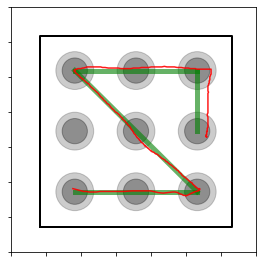

participant_id: 4
try number: 13


,type,dot_number,x_value,y_value
0,dot,8,6660.0,2364.0
1,dot,4,5787.0,3228.0
2,dot,0,4914.0,4092.0
3,dot,1,5787.0,4092.0
4,dot,2,6660.0,4092.0
5,dot,4,5787.0,3228.0
6,dot,6,4914.0,2364.0
7,dot,3,4914.0,3228.0


,dots_intersected,start,end,start_oob,end_oob
0,"[8, 4, 0]","[6660.0, 2364.0]","[4914.0, 4092.0]",0,0
1,"[0, 1, 2]","[4914.0, 4092.0]","[6660.0, 4092.0]",0,0
2,"[2, 4, 6]","[6660.0, 4092.0]","[4914.0, 2364.0]",0,0
3,"[6, 3]","[4914.0, 2364.0]","[4914.0, 3228.0]",0,0


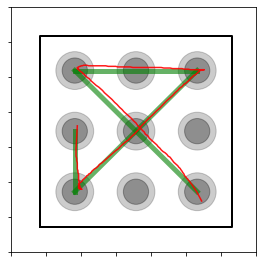

participant_id: 4
try number: 14


,type,dot_number,x_value,y_value
0,dot,6,4914.0,2364.0
1,dot,1,5787.0,4092.0
2,dot,5,6660.0,3228.0
3,dot,8,6660.0,2364.0
4,dot,5,6660.0,3228.0
5,dot,2,6660.0,4092.0
6,dot,7,5787.0,2364.0


,dots_intersected,start,end,start_oob,end_oob
0,"[6, 1]","[4914.0, 2364.0]","[5787.0, 4092.0]",0,0
1,"[1, 5]","[5787.0, 4092.0]","[6660.0, 3228.0]",0,0
2,"[5, 8, 5, 2]","[6660.0, 3228.0]","[6660.0, 4092.0]",0,0
3,"[2, 7]","[6660.0, 4092.0]","[5787.0, 2364.0]",0,0


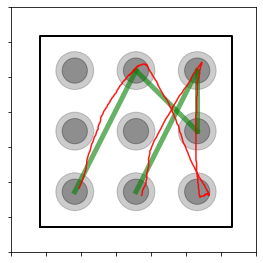

participant_id: 4
try number: 15


,type,dot_number,x_value,y_value
0,dot,2,6660.0,4092.0
1,dot,3,4914.0,3228.0
2,dot,8,6660.0,2364.0
3,dot,4,5787.0,3228.0
4,dot,0,4914.0,4092.0
5,dot,1,5787.0,4092.0
6,dot,2,6660.0,4092.0


,dots_intersected,start,end,start_oob,end_oob
0,"[2, 3]","[6660.0, 4092.0]","[4914.0, 3228.0]",0,0
1,"[3, 8]","[4914.0, 3228.0]","[6660.0, 2364.0]",0,0
2,"[8, 4, 0]","[6660.0, 2364.0]","[4914.0, 4092.0]",0,0
3,"[0, 1, 2]","[4914.0, 4092.0]","[6660.0, 4092.0]",0,0


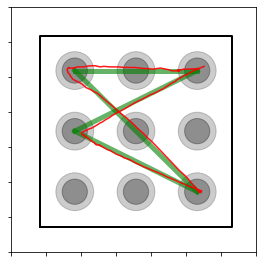

participant_id: 4
try number: 16


,type,dot_number,x_value,y_value
0,dot,0,4914.0,4092.0
1,dot,5,6660.0,3228.0
2,dot,8,6660.0,2364.0
3,dot,7,5787.0,2364.0
4,dot,6,4914.0,2364.0
5,dot,4,5787.0,3228.0
6,dot,2,6660.0,4092.0


,dots_intersected,start,end,start_oob,end_oob
0,"[0, 5]","[4914.0, 4092.0]","[6660.0, 3228.0]",0,0
1,"[5, 8]","[6660.0, 3228.0]","[6660.0, 2364.0]",0,0
2,"[8, 7, 6]","[6660.0, 2364.0]","[4914.0, 2364.0]",0,0
3,"[6, 4, 2]","[4914.0, 2364.0]","[6660.0, 4092.0]",0,0


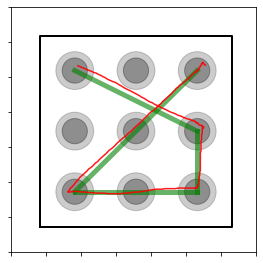

participant_id: 4
try number: 17


,type,dot_number,x_value,y_value
0,dot,5,6660.0,3228.0
1,dot,7,5787.0,2364.0
2,dot,3,4914.0,3228.0
3,dot,1,5787.0,4092.0
4,dot,4,5787.0,3228.0


,dots_intersected,start,end,start_oob,end_oob
0,"[5, 7]","[6660.0, 3228.0]","[5787.0, 2364.0]",0,0
1,"[7, 3]","[5787.0, 2364.0]","[4914.0, 3228.0]",0,0
2,"[3, 1]","[4914.0, 3228.0]","[5787.0, 4092.0]",0,0
3,"[1, 4]","[5787.0, 4092.0]","[5787.0, 3228.0]",0,0


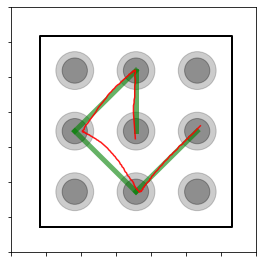

participant_id: 4
try number: 18


,type,dot_number,x_value,y_value
0,dot,7,5787.0,2364.0
1,dot,3,4914.0,3228.0
2,dot,1,5787.0,4092.0
3,dot,5,6660.0,3228.0
4,dot,7,5787.0,2364.0


,dots_intersected,start,end,start_oob,end_oob
0,"[7, 3]","[5787.0, 2364.0]","[4914.0, 3228.0]",0,0
1,"[3, 1]","[4914.0, 3228.0]","[5787.0, 4092.0]",0,0
2,"[1, 5]","[5787.0, 4092.0]","[6660.0, 3228.0]",0,0
3,"[5, 7]","[6660.0, 3228.0]","[5787.0, 2364.0]",0,0


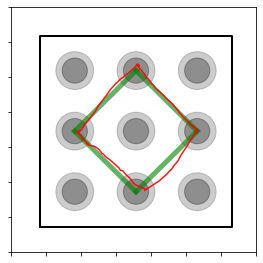

participant_id: 4
try number: 19


,type,dot_number,x_value,y_value
0,dot,0,4914.0,4092.0
1,dot,1,5787.0,4092.0
2,dot,2,6660.0,4092.0
3,dot,5,6660.0,3228.0
4,dot,8,6660.0,2364.0
5,dot,4,5787.0,3228.0
6,dot,3,4914.0,3228.0


,dots_intersected,start,end,start_oob,end_oob
0,"[0, 1, 2]","[4914.0, 4092.0]","[6660.0, 4092.0]",0,0
1,"[2, 5, 8]","[6660.0, 4092.0]","[6660.0, 2364.0]",0,0
2,"[8, 4]","[6660.0, 2364.0]","[5787.0, 3228.0]",0,0
3,"[4, 3]","[5787.0, 3228.0]","[4914.0, 3228.0]",0,0


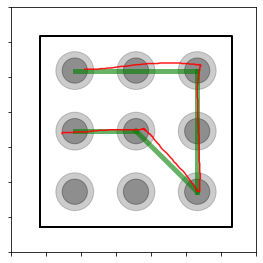

participant_id: 4
try number: 20


,type,dot_number,x_value,y_value
0,dot,6,4914.0,2364.0
1,dot,7,5787.0,2364.0
2,dot,8,6660.0,2364.0
3,dot,3,4914.0,3228.0
4,dot,4,5787.0,3228.0
5,dot,5,6660.0,3228.0
6,dot,2,6660.0,4092.0


,dots_intersected,start,end,start_oob,end_oob
0,"[6, 7, 8]","[4914.0, 2364.0]","[6660.0, 2364.0]",0,0
1,"[8, 3]","[6660.0, 2364.0]","[4914.0, 3228.0]",0,0
2,"[3, 4, 5]","[4914.0, 3228.0]","[6660.0, 3228.0]",0,0
3,"[5, 2]","[6660.0, 3228.0]","[6660.0, 4092.0]",0,0


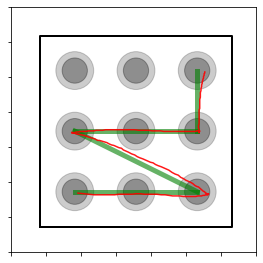

participant_id: 4
try number: 21


,type,dot_number,x_value,y_value
0,dot,2,6660.0,4092.0
1,dot,3,4914.0,3228.0
2,dot,6,4914.0,2364.0
3,dot,7,5787.0,2364.0
4,dot,8,6660.0,2364.0


,dots_intersected,start,end,start_oob,end_oob
0,"[2, 3]","[6660.0, 4092.0]","[4914.0, 3228.0]",0,0
1,"[3, 6]","[4914.0, 3228.0]","[4914.0, 2364.0]",0,0
2,"[6, 7, 8]","[4914.0, 2364.0]","[6660.0, 2364.0]",0,0


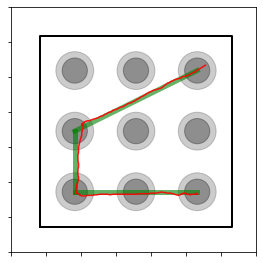

participant_id: 4
try number: 22


,type,dot_number,x_value,y_value
0,dot,0,4914.0,4092.0
1,dot,3,4914.0,3228.0
2,dot,6,4914.0,2364.0
3,dot,7,5787.0,2364.0
4,dot,8,6660.0,2364.0
5,dot,5,6660.0,3228.0
6,dot,2,6660.0,4092.0
7,dot,4,5787.0,3228.0


,dots_intersected,start,end,start_oob,end_oob
0,"[0, 3, 6]","[4914.0, 4092.0]","[4914.0, 2364.0]",0,0
1,"[6, 7, 8]","[4914.0, 2364.0]","[6660.0, 2364.0]",0,0
2,"[8, 5, 2]","[6660.0, 2364.0]","[6660.0, 4092.0]",0,0
3,"[2, 4]","[6660.0, 4092.0]","[5787.0, 3228.0]",0,0


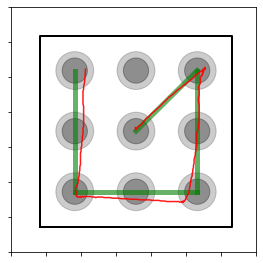

participant_id: 4
try number: 23


,type,dot_number,x_value,y_value
0,dot,7,5787.0,2364.0
1,dot,4,5787.0,3228.0
2,dot,1,5787.0,4092.0
3,dot,0,4914.0,4092.0
4,dot,3,4914.0,3228.0
5,dot,6,4914.0,2364.0
6,dot,7,5787.0,2364.0
7,dot,8,6660.0,2364.0


,dots_intersected,start,end,start_oob,end_oob
0,"[7, 4, 1]","[5787.0, 2364.0]","[5787.0, 4092.0]",0,0
1,"[1, 0]","[5787.0, 4092.0]","[4914.0, 4092.0]",0,0
2,"[0, 3, 6]","[4914.0, 4092.0]","[4914.0, 2364.0]",0,0
3,"[6, 7, 8]","[4914.0, 2364.0]","[6660.0, 2364.0]",0,0


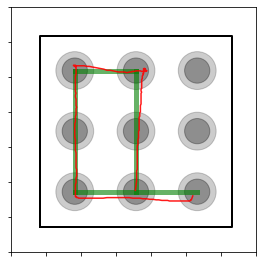

participant_id: 4
try number: 24


,type,dot_number,x_value,y_value
0,dot,8,6660.0,2364.0
1,dot,5,6660.0,3228.0
2,dot,2,6660.0,4092.0
3,dot,1,5787.0,4092.0
4,dot,0,4914.0,4092.0
5,dot,4,5787.0,3228.0
6,dot,6,4914.0,2364.0


,dots_intersected,start,end,start_oob,end_oob
0,"[8, 5, 2]","[6660.0, 2364.0]","[6660.0, 4092.0]",0,0
1,"[2, 1, 0]","[6660.0, 4092.0]","[4914.0, 4092.0]",0,0
2,"[0, 4]","[4914.0, 4092.0]","[5787.0, 3228.0]",0,0
3,"[4, 6]","[5787.0, 3228.0]","[4914.0, 2364.0]",0,0


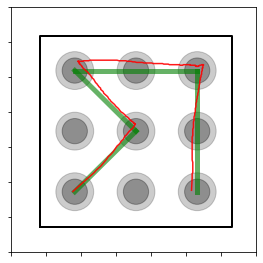

participant_id: 4
try number: 25


,type,dot_number,x_value,y_value
0,dot,6,4914.0,2364.0
1,dot,7,5787.0,2364.0
2,dot,8,6660.0,2364.0
3,dot,4,5787.0,3228.0
4,dot,0,4914.0,4092.0
5,dot,1,5787.0,4092.0
6,dot,2,6660.0,4092.0
7,dot,5,6660.0,3228.0


,dots_intersected,start,end,start_oob,end_oob
0,"[6, 7, 8]","[4914.0, 2364.0]","[6660.0, 2364.0]",0,0
1,"[8, 4, 0]","[6660.0, 2364.0]","[4914.0, 4092.0]",0,0
2,"[0, 1, 2]","[4914.0, 4092.0]","[6660.0, 4092.0]",0,0
3,"[2, 5]","[6660.0, 4092.0]","[6660.0, 3228.0]",0,0


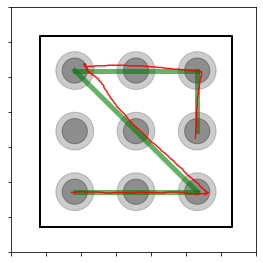

participant_id: 4
try number: 26


,type,dot_number,x_value,y_value
0,dot,4,5787.0,3228.0
1,dot,8,6660.0,2364.0
2,dot,5,6660.0,3228.0
3,dot,2,6660.0,4092.0
4,dot,1,5787.0,4092.0
5,dot,0,4914.0,4092.0
6,dot,3,4914.0,3228.0
7,dot,6,4914.0,2364.0


,dots_intersected,start,end,start_oob,end_oob
0,"[4, 8]","[5787.0, 3228.0]","[6660.0, 2364.0]",0,0
1,"[8, 5, 2]","[6660.0, 2364.0]","[6660.0, 4092.0]",0,0
2,"[2, 1, 0]","[6660.0, 4092.0]","[4914.0, 4092.0]",0,0
3,"[0, 3, 6]","[4914.0, 4092.0]","[4914.0, 2364.0]",0,0


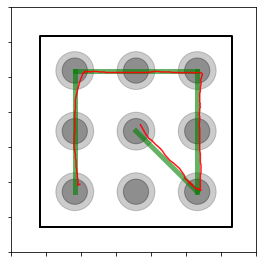

participant_id: 4
try number: 27


,type,dot_number,x_value,y_value
0,dot,3,4914.0,3228.0
1,dot,1,5787.0,4092.0
2,dot,5,6660.0,3228.0
3,dot,7,5787.0,2364.0
4,dot,6,4914.0,2364.0


,dots_intersected,start,end,start_oob,end_oob
0,"[3, 1]","[4914.0, 3228.0]","[5787.0, 4092.0]",0,0
1,"[1, 5]","[5787.0, 4092.0]","[6660.0, 3228.0]",0,0
2,"[5, 7]","[6660.0, 3228.0]","[5787.0, 2364.0]",0,0
3,"[7, 6]","[5787.0, 2364.0]","[4914.0, 2364.0]",0,0


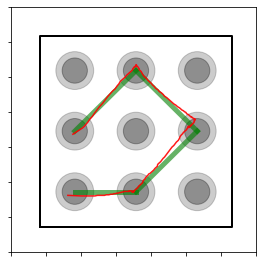

participant_id: 4
try number: 28


,type,dot_number,x_value,y_value
0,dot,6,4914.0,2364.0
1,dot,7,5787.0,2364.0
2,dot,8,6660.0,2364.0
3,dot,4,5787.0,3228.0
4,dot,0,4914.0,4092.0
5,dot,1,5787.0,4092.0
6,dot,2,6660.0,4092.0
7,dot,5,6660.0,3228.0


,dots_intersected,start,end,start_oob,end_oob
0,"[6, 7, 8]","[4914.0, 2364.0]","[6660.0, 2364.0]",0,0
1,"[8, 4, 0]","[6660.0, 2364.0]","[4914.0, 4092.0]",0,0
2,"[0, 1, 2]","[4914.0, 4092.0]","[6660.0, 4092.0]",0,0
3,"[2, 5]","[6660.0, 4092.0]","[6660.0, 3228.0]",0,0


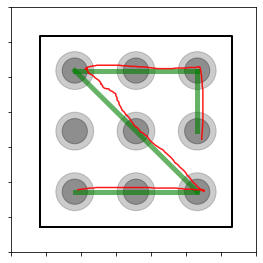

participant_id: 4
try number: 29


,type,dot_number,x_value,y_value
0,dot,8,6660.0,2364.0
1,dot,4,5787.0,3228.0
2,dot,0,4914.0,4092.0
3,dot,1,5787.0,4092.0
4,dot,2,6660.0,4092.0
5,dot,4,5787.0,3228.0
6,dot,6,4914.0,2364.0
7,dot,3,4914.0,3228.0


,dots_intersected,start,end,start_oob,end_oob
0,"[8, 4, 0]","[6660.0, 2364.0]","[4914.0, 4092.0]",0,0
1,"[0, 1, 2]","[4914.0, 4092.0]","[6660.0, 4092.0]",0,0
2,"[2, 4, 6]","[6660.0, 4092.0]","[4914.0, 2364.0]",0,0
3,"[6, 3]","[4914.0, 2364.0]","[4914.0, 3228.0]",0,0


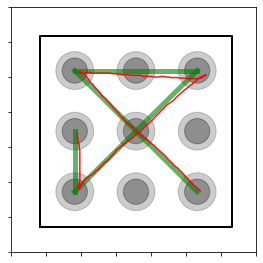

participant_id: 4
try number: 30


,type,dot_number,x_value,y_value
0,dot,8,6660.0,2364.0
1,dot,5,6660.0,3228.0
2,dot,2,6660.0,4092.0
3,dot,4,5787.0,3228.0
4,dot,6,4914.0,2364.0
5,dot,3,4914.0,3228.0
6,dot,0,4914.0,4092.0
7,dot,1,5787.0,4092.0


,dots_intersected,start,end,start_oob,end_oob
0,"[8, 5, 2]","[6660.0, 2364.0]","[6660.0, 4092.0]",0,0
1,"[2, 4, 6]","[6660.0, 4092.0]","[4914.0, 2364.0]",0,0
2,"[6, 3, 0]","[4914.0, 2364.0]","[4914.0, 4092.0]",0,0
3,"[0, 1]","[4914.0, 4092.0]","[5787.0, 4092.0]",0,0


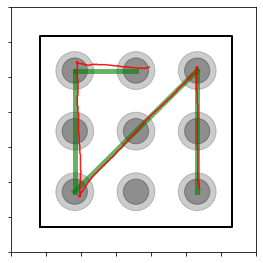

participant_id: 4
try number: 31


,type,dot_number,x_value,y_value
0,dot,6,4914.0,2364.0
1,dot,3,4914.0,3228.0
2,dot,0,4914.0,4092.0
3,dot,7,5787.0,2364.0
4,dot,4,5787.0,3228.0
5,dot,1,5787.0,4092.0
6,dot,2,6660.0,4092.0


,dots_intersected,start,end,start_oob,end_oob
0,"[6, 3, 0]","[4914.0, 2364.0]","[4914.0, 4092.0]",0,0
1,"[0, 7]","[4914.0, 4092.0]","[5787.0, 2364.0]",0,0
2,"[7, 4, 1]","[5787.0, 2364.0]","[5787.0, 4092.0]",0,0
3,"[1, 2]","[5787.0, 4092.0]","[6660.0, 4092.0]",0,0


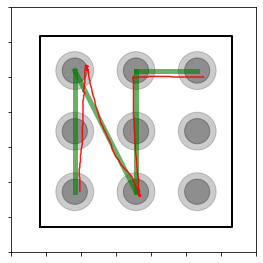

participant_id: 4
try number: 32


,type,dot_number,x_value,y_value
0,dot,6,4914.0,2364.0
1,dot,7,5787.0,2364.0
2,dot,8,6660.0,2364.0
3,dot,4,5787.0,3228.0
4,dot,0,4914.0,4092.0
5,dot,1,5787.0,4092.0
6,dot,2,6660.0,4092.0
7,dot,5,6660.0,3228.0


,dots_intersected,start,end,start_oob,end_oob
0,"[6, 7, 8]","[4914.0, 2364.0]","[6660.0, 2364.0]",0,0
1,"[8, 4, 0]","[6660.0, 2364.0]","[4914.0, 4092.0]",0,0
2,"[0, 1, 2]","[4914.0, 4092.0]","[6660.0, 4092.0]",0,0
3,"[2, 5]","[6660.0, 4092.0]","[6660.0, 3228.0]",0,0


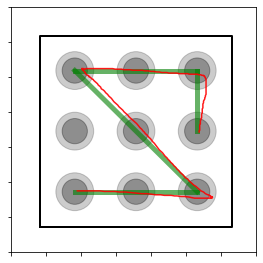

participant_id: 4
try number: 33


,type,dot_number,x_value,y_value
0,dot,5,6660.0,3228.0
1,dot,4,5787.0,3228.0
2,dot,3,4914.0,3228.0
3,dot,8,6660.0,2364.0
4,dot,7,5787.0,2364.0
5,dot,6,4914.0,2364.0
6,dot,4,5787.0,3228.0
7,dot,2,6660.0,4092.0


,dots_intersected,start,end,start_oob,end_oob
0,"[5, 4, 3]","[6660.0, 3228.0]","[4914.0, 3228.0]",0,0
1,"[3, 8]","[4914.0, 3228.0]","[6660.0, 2364.0]",0,0
2,"[8, 7, 6]","[6660.0, 2364.0]","[4914.0, 2364.0]",0,0
3,"[6, 4, 2]","[4914.0, 2364.0]","[6660.0, 4092.0]",0,0


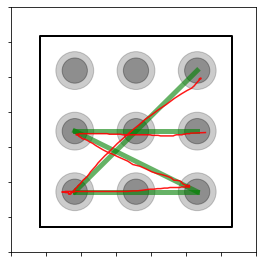

participant_id: 4
try number: 34


,type,dot_number,x_value,y_value
0,dot,3,4914.0,3228.0
1,dot,0,4914.0,4092.0
2,dot,1,5787.0,4092.0
3,dot,2,6660.0,4092.0
4,dot,5,6660.0,3228.0
5,dot,8,6660.0,2364.0
6,dot,7,5787.0,2364.0
7,dot,6,4914.0,2364.0


,dots_intersected,start,end,start_oob,end_oob
0,"[3, 0]","[4914.0, 3228.0]","[4914.0, 4092.0]",0,0
1,"[0, 1, 2]","[4914.0, 4092.0]","[6660.0, 4092.0]",0,0
2,"[2, 5, 8]","[6660.0, 4092.0]","[6660.0, 2364.0]",0,0
3,"[8, 7, 6]","[6660.0, 2364.0]","[4914.0, 2364.0]",0,0


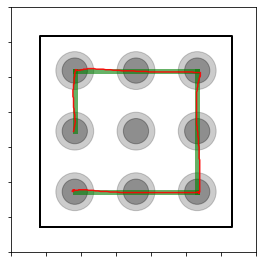

participant_id: 4
try number: 35


,type,dot_number,x_value,y_value
0,dot,4,5787.0,3228.0
1,dot,0,4914.0,4092.0
2,dot,5,6660.0,3228.0
3,dot,8,6660.0,2364.0
4,dot,7,5787.0,2364.0
5,dot,6,4914.0,2364.0


,dots_intersected,start,end,start_oob,end_oob
0,"[4, 0]","[5787.0, 3228.0]","[4914.0, 4092.0]",0,0
1,"[0, 5]","[4914.0, 4092.0]","[6660.0, 3228.0]",0,0
2,"[5, 8]","[6660.0, 3228.0]","[6660.0, 2364.0]",0,0
3,"[8, 7, 6]","[6660.0, 2364.0]","[4914.0, 2364.0]",0,0


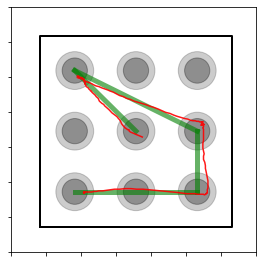

participant_id: 4
try number: 36


,type,dot_number,x_value,y_value
0,dot,6,4914.0,2364.0
1,dot,3,4914.0,3228.0
2,dot,0,4914.0,4092.0
3,dot,1,5787.0,4092.0
4,dot,2,6660.0,4092.0


,dots_intersected,start,end,start_oob,end_oob
0,"[6, 3, 0]","[4914.0, 2364.0]","[4914.0, 4092.0]",0,0
1,"[0, 1, 2]","[4914.0, 4092.0]","[6660.0, 4092.0]",0,0


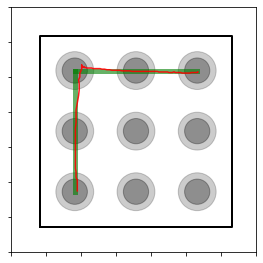

participant_id: 4
try number: 37


,type,dot_number,x_value,y_value
0,dot,8,6660.0,2364.0
1,dot,4,5787.0,3228.0
2,dot,0,4914.0,4092.0
3,dot,3,4914.0,3228.0
4,dot,4,5787.0,3228.0
5,dot,5,6660.0,3228.0
6,dot,2,6660.0,4092.0


,dots_intersected,start,end,start_oob,end_oob
0,"[8, 4, 0]","[6660.0, 2364.0]","[4914.0, 4092.0]",0,0
1,"[0, 3]","[4914.0, 4092.0]","[4914.0, 3228.0]",0,0
2,"[3, 4, 5]","[4914.0, 3228.0]","[6660.0, 3228.0]",0,0
3,"[5, 2]","[6660.0, 3228.0]","[6660.0, 4092.0]",0,0


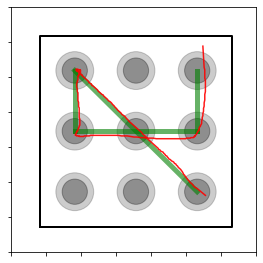

participant_id: 4
try number: 38


,type,dot_number,x_value,y_value
0,dot,6,4914.0,2364.0
1,dot,7,5787.0,2364.0
2,dot,8,6660.0,2364.0
3,dot,4,5787.0,3228.0
4,dot,0,4914.0,4092.0
5,dot,1,5787.0,4092.0
6,dot,2,6660.0,4092.0
7,dot,5,6660.0,3228.0


,dots_intersected,start,end,start_oob,end_oob
0,"[6, 7, 8]","[4914.0, 2364.0]","[6660.0, 2364.0]",0,0
1,"[8, 4, 0]","[6660.0, 2364.0]","[4914.0, 4092.0]",0,0
2,"[0, 1, 2]","[4914.0, 4092.0]","[6660.0, 4092.0]",0,0
3,"[2, 5]","[6660.0, 4092.0]","[6660.0, 3228.0]",0,0


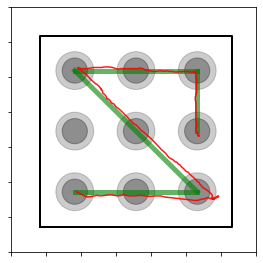

participant_id: 4
try number: 39


,type,dot_number,x_value,y_value
0,dot,7,5787.0,2364.0
1,dot,3,4914.0,3228.0
2,dot,0,4914.0,4092.0
3,dot,1,5787.0,4092.0
4,dot,2,6660.0,4092.0
5,dot,5,6660.0,3228.0
6,dot,8,6660.0,2364.0


,dots_intersected,start,end,start_oob,end_oob
0,"[7, 3]","[5787.0, 2364.0]","[4914.0, 3228.0]",0,0
1,"[3, 0]","[4914.0, 3228.0]","[4914.0, 4092.0]",0,0
2,"[0, 1, 2]","[4914.0, 4092.0]","[6660.0, 4092.0]",0,0
3,"[2, 5, 8]","[6660.0, 4092.0]","[6660.0, 2364.0]",0,0


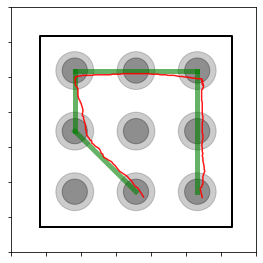

participant_id: 4
try number: 40
empty try


In [15]:
data = pd.read_csv(filenames[2])  
dots = data.iloc[6:9, 1:5]
dots = dots.append(data.iloc[11:14, 1:5], sort = False)
dots = dots.append(data.iloc[16:19, 1:5], sort = False)
dots = dots.rename(columns = {dots.columns[0]:'left_border', dots.columns[1]:'upper_border', dots.columns[2]:'width', dots.columns[3]:'height'})
dots = dots.astype('float')
dots.loc[: , 'left_border'] = 9 * dots.loc[: , 'left_border']
dots.loc[: , 'upper_border'] = 8 * dots.loc[: , 'upper_border']
dots.loc[: , 'width'] = 9 * dots.loc[: , 'width']
dots.loc[: , 'height'] = 8 * dots.loc[: , 'height']
dots['center_x'] = dots['left_border'] + dots['width'] / 2
dots['center_y'] = dots['upper_border'] + dots['height'] / 2 #what should be upper border apparently is lower border
dots = dots.sort_values(["center_y", "center_x"], ascending=[False, True])
dots = dots.reset_index(drop = True)
print('the dots')
display(dots)

for f in range(len(filenames)):
    if f == 4:
        data = pd.read_csv(filenames[f])  

        main = data.iloc[29:, 1:5]
        main = main.rename(columns = {main.columns[0]:'try_number', main.columns[1]:'inner_index', main.columns[2]:'x_value', main.columns[3]:'y_value'})
        main = main.reset_index(drop = True)
        main = main.astype({'try_number':'int', 'inner_index':'int', 'x_value':'float', 'y_value':'float'})
        main.loc[: , 'x_value'] = 9 * main.loc[: , 'x_value']
        main.loc[: , 'y_value'] = 8 * main.loc[: , 'y_value']

        for t in range(max(main['try_number'])):
        #if t == 8:
            print('participant_id: ' + str(f))
            print('try number: ' + str(t))
            single_try = main[main['try_number'] == t + 1]

            if len(single_try) > 1:
                res = get_lines(single_try)
                display(res)

                fig, axs = plt.subplots(1,1)
                for l in range(len(res)): #plotting the result
                    plt.plot([res.loc[l, 'start'][0], res.loc[l, 'end'][0]], 
                             [res.loc[l, 'start'][1], res.loc[l, 'end'][1]], 'g', alpha = 0.6, linewidth = 5)

                for i in range(len(dots)): #plotting the dots in real size
                    circle = plt.Circle((dots.loc[i, 'center_x'], dots.loc[i, 'center_y']), dot_radius, color='k', alpha = 0.3)
                    plt.gca().add_patch(circle)

                for i in range(len(dots)): #plotting the dots neighbourhood
                    circle = plt.Circle((dots.loc[i, 'center_x'], dots.loc[i, 'center_y']), dot_radius + max_dot_error, color='k', alpha = 0.2)
                    plt.gca().add_patch(circle)

                #plotting outer border
                plt.plot([min(dots['center_x']) - outer_border_dist, 
                            min(dots['center_x']) - outer_border_dist, 
                            max(dots['center_x']) + outer_border_dist, 
                            max(dots['center_x']) + outer_border_dist,
                            min(dots['center_x']) - outer_border_dist],
                         [min(dots['center_y']) - outer_border_dist, 
                            max(dots['center_y']) + outer_border_dist,
                            max(dots['center_y']) + outer_border_dist,
                            min(dots['center_y']) - outer_border_dist,
                            min(dots['center_y']) - outer_border_dist],
                        'k', linewidth = 2)

                plt.plot(single_try['x_value'], single_try['y_value'], 'r', alpha = 0.9)

                plt.xlim(4000,7500)
                plt.ylim(1500, 5000)
                axs.set_aspect('equal', 'box')
                fig.tight_layout()
                plt.xticks(visible = False)
                plt.yticks(visible = False)
                plt.show()

            else:
                print('empty try')
